# Feature Engineering with FinBert Sentiment Analysis

In [9]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [10]:
%cd /gdrive/MyDrive/FinBERT-master

/gdrive/.shortcut-targets-by-id/1JvExEShzINZC-jPtjJWYkZVznGAdWYoV/FinBERT-master


In [12]:
!pip install transformers
!pip install pytorch_pretrained_bert
!pip install num2words
!pip install lexrank
!pip install sumy

     |████████████████████████████████| 2.2MB 7.8MB/s 
     |████████████████████████████████| 870kB 48.9MB/s 
     |████████████████████████████████| 3.3MB 48.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=4c2a0c7aa7eb1019d54c6535bfddf27a802a09147322515dee2f8b9ec323286e
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 133kB 8.4MB/s 
     |████████████████████████████████| 133kB 13.8MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 7.4MB 13.7MB/s 
ERROR: botocore 1.20.47 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 102kB 6.1MB/s 
     |████████████████████████████████| 71kB 5.2MB/s 
     |████████████████████████████████| 92kB 6.3MB/s 
     |████████████████████████████

In [50]:
import os
from transformers import BertModel, BertConfig
import copy
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from bertModel import BertClassification, dense_opt
from datasets import text_dataset, financialPhraseBankDataset
import argparse
from sklearn.metrics import f1_score
from joblib import dump, load
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from num2words import num2words
import nltk
import string
import pickle
import math
from lexrank import STOPWORDS, LexRank
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
import tqdm
from csv import writer
import matplotlib.pyplot as plt

In [14]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Creating a Bert classification model with pretrained FinBert weights

In [15]:
labels = {0:'neutral', 1:'positive', 2:'negative'}
num_labels= len(labels)
vocab = "finance-uncased"
vocab_path = 'analyst_tone/vocab'
pretrained_weights_path = "analyst_tone/pretrained_weights" # this is pre-trained FinBERT weights
fine_tuned_weight_path = "analyst_tone/fine_tuned.pth"      # this is fine-tuned FinBERT weights
max_seq_length=256
device='cuda:1'

#### Creating the classifier with the fine-tuned weights

In [16]:
model = BertClassification(weight_path=pretrained_weights_path, 
                           num_labels=num_labels, 
                           vocab=vocab)

/gdrive/.shortcut-targets-by-id/1JvExEShzINZC-jPtjJWYkZVznGAdWYoV/FinBERT-master/bertModel.py:31: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.classifier.weight)


A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor. Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) and registered buffers (batchnorm’s running_mean) have entries in the model’s state_dict. 

In [18]:
model.load_state_dict(torch.load(fine_tuned_weight_path, 
                                 map_location=torch.device('cpu')))

<All keys matched successfully>

#### Testing the classifier on a few sentences. 
- 0 is neutral
- 1 is positive, and 
- 2 is negative 

In [19]:
sentences = ['there is a shortage of capital, and we need extra financing', 
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat"]

In [20]:
tokenizer = BertTokenizer(vocab_file=vocab_path, 
                          do_lower_case=True, 
                          do_basic_tokenize=True)

In [21]:
model.eval()
senti = []
for sent in sentences: 
    tokenized_sent = tokenizer.tokenize(sent)
    if len(tokenized_sent) > max_seq_length:
        tokenized_sent = tokenized_sent[:max_seq_length]
    
    ids_review  = tokenizer.convert_tokens_to_ids(tokenized_sent)
    mask_input = [1]*len(ids_review)        
    padding = [0] * (max_seq_length - len(ids_review))
    ids_review += padding
    mask_input += padding
    input_type = [0]*max_seq_length
    
    input_ids = torch.tensor(ids_review).reshape(-1, 256)
    attention_mask =  torch.tensor(mask_input).reshape(-1, 256)
    token_type_ids = torch.tensor(input_type).reshape(-1, 256)
    
    with torch.set_grad_enabled(False):
        outputs = model(input_ids, token_type_ids, attention_mask)
        outputs = F.softmax(outputs,dim=1)
        senti.append(labels[torch.argmax(outputs).item()])
        # print(sent, '\nFinBERT predicted sentiment: ', labels[torch.argmax(outputs).item()], '\n')

sentiment_df = pd.DataFrame(list(zip(sentences, senti)), columns=['Sentence', 'FinBert Sentiment'])

In [22]:
sentiment_df

,Sentence,FinBert Sentiment
0,"there is a shortage of capital, and we need ex...",negative
1,growth is strong and we have plenty of liquidity,positive
2,there are doubts about our finances,negative
3,profits are flat,neutral


### Comparing to a Naive Bayes model pre-trained on a 10,000 analyst sentiment dataset

In [23]:
def convert_lower_case(data):
    return np.char.lower(data)

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = stemming(data) #needed again as we need to stem the words
    data = remove_punctuation(data) #needed again as num2word is giving few hypens and commas fourty-one
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one
    return data

In [24]:
pre_proc_X = [preprocess(t) for t in sentences]

In [25]:
best_model= load('./naive_tfidf.joblib')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. U

In [26]:
pred_prob = best_model.predict_proba(pre_proc_X)

In [27]:
nb_senti = []
for idx, sent in enumerate(sentences):
    nb_senti.append(labels[np.argmax(pred_prob[idx])])

sentiment_df['Naive Bayes Sentiment'] = nb_senti

In [28]:
sentiment_df

,Sentence,FinBert Sentiment,Naive Bayes Sentiment
0,"there is a shortage of capital, and we need ex...",negative,negative
1,growth is strong and we have plenty of liquidity,positive,positive
2,there are doubts about our finances,negative,positive
3,profits are flat,neutral,positive


As Seen, FINBERT makes more sense in its prediction compared to the naive bayes base model. However, Bert has a limit on number of tokens it can predict. Instead of breaking long text to separate sentences, we decide to use LexRank to summarize the main points of the text and then use FINBERT on it




### Summarizing using LexRank and classifying the sentiment of the text

In [29]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [30]:
df = pd.read_csv('raw_data.txt')

In [31]:
df.head()

,date,DFEDTARL,DFEDTARU,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,minutes,speeches,statements,testimony,pressconf,text
0,2006-01-31,NaN,NaN,15267.026,199.3,4.7,135429.0,179293.0,8371156.0,12.050690,4.285161,A meeting of the Federal Open Market Committe...,I thank you for the invitation to speak today...,The Federal Open Market Committee decided tod...,Chairman Bernanke presented identical testimo...,CHAIRMAN GREENSPAN. Thank you all very much....,A meeting of the Federal Open Market Committe...
1,2006-02-28,NaN,NaN,15267.026,199.4,4.8,135737.0,177887.0,8371156.0,12.412857,4.491429,A meeting of the Federal Open Market Committe...,I appreciate the opportunity to speak to you ...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Welcome, everyone. It ha...",A meeting of the Federal Open Market Committe...
2,2006-03-31,NaN,NaN,15267.026,199.7,4.7,136047.0,178100.0,8371156.0,11.716129,4.589355,NaN,I am pleased to participate in the panel disc...,NaN,"Mr. Chairman and members of the Committee, I ...",NaN,I am pleased to participate in the panel disc...
3,2006-04-30,NaN,NaN,15302.705,200.7,4.7,136205.0,178088.0,8420042.0,11.863333,4.790333,A meeting of the Federal Open Market Committe...,I would like to thank Operation HOPE and the ...,The Federal Open Market Committee decided tod...,"Chairman Hagel, Senator Dodd, and members of ...","CHAIRMAN BERNANKE. Good morning, everyone. ...",A meeting of the Federal Open Market Committe...
4,2006-05-31,NaN,NaN,15302.705,201.3,4.6,136244.0,177200.0,8420042.0,14.411613,4.940323,A meeting of the Federal Open Market Committe...,I am pleased to be here this afternoon to par...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Good afternoon, everybody...",A meeting of the Federal Open Market Committe...


In [32]:
text = df.text.values
text = text[:-1]

In [33]:
text[:5]

array([' A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, January 31, 2006 at 9:00 a.m.Mses. Cumming and Minehan, Messrs. Moskow, Poole, and Hoenig, Alternate Members of the Federal Open Market CommitteeMessrs. Fisher, Stern, and Santomero, Presidents of the Federal Reserve \nBanks of Dallas, Minneapolis, and Philadelphia, respectivelyMr. Reinhart, Secretary and Economist\n\t\tMs. Danker, Deputy Secretary\n\t\tMs. Smith, Assistant Secretary\n\t\tMr. Skidmore, Assistant Secretary\n\t\tMr. Alvarez, General Counsel\n\t\tMr. Baxter, Deputy General Counsel\n\t\tMs. Johnson, Economist\n\t\tMr. Stockton, EconomistMessrs. Connors, Eisenbeis, Judd, Kamin, Madigan, Sniderman, Struckmeyer,   \nand Wilcox, Associate EconomistsMr. Kos, Manager, System Open Market AccountMessrs. Oliner and Slifman, Associate Directors, Division of Research and Statistics, Board of GovernorsMr. Whitesell, De

In [34]:
def create_txt(text_arr):
  my_dir = "/gdrive/.shortcut-targets-by-id/1JvExEShzINZC-jPtjJWYkZVznGAdWYoV/FinBERT-master/text_files"
  try:
    path, dirs, files = next(os.walk(my_dir))
    file_count = len(files)
    if file_count != len(text_arr):
      filelist = [ f for f in os.listdir(my_dir) if f.endswith(".txt") ]
      for f in filelist:
        os.remove(os.path.join(my_dir, f))
      raise Exception
  except:

    row_count = 0
    for t in text_arr:
      to_create = my_dir + '/row_' + str(row_count) + '.txt'
      f = open(to_create, "x")
      f.write(t)
      f.close()
      row_count += 1

In [35]:
create_txt(text)

In [36]:
def predict(start):
  if 1==1:
    iters = 182 - start
    pbar = tqdm.tqdm(total=iters)
    my_dir = "/gdrive/.shortcut-targets-by-id/1JvExEShzINZC-jPtjJWYkZVznGAdWYoV/FinBERT-master/text_files"
    # for filename in os.listdir(my_dir):
    for filename in os.listdir(my_dir)[start:]:
      #print(filename)
      to_open = my_dir + '/' + filename
      temp = open(to_open,'r').read().split('\n')
      split = get_split(temp[0])
      p = PlaintextParser.from_file(to_open, Tokenizer("english"))
      summarizer = LexRankSummarizer() #creating lexrank object
      summ = summarizer(p.document, 10) #Summarizing the document
      summarized = []
      for s in summ:
        #print(s)
        if len(str(s)) > 1:
          summarized.append(str(s))
      sentiment = []
      model.eval()
      for sent in summarized: 
          tokenized_sent = tokenizer.tokenize(sent)
          if len(tokenized_sent) > max_seq_length:
              tokenized_sent = tokenized_sent[:max_seq_length]
          
          ids_review  = tokenizer.convert_tokens_to_ids(tokenized_sent)
          mask_input = [1]*len(ids_review)        
          padding = [0] * (max_seq_length - len(ids_review))
          ids_review += padding
          mask_input += padding
          input_type = [0]*max_seq_length
          
          input_ids = torch.tensor(ids_review).reshape(-1, 256)
          attention_mask =  torch.tensor(mask_input).reshape(-1, 256)
          token_type_ids = torch.tensor(input_type).reshape(-1, 256)
          
          with torch.set_grad_enabled(False):
              outputs = model(input_ids, token_type_ids, attention_mask)
              outputs = F.softmax(outputs,dim=1)
              #print(sent, '\nFinBERT predicted sentiment: ', labels[torch.argmax(outputs).item()], '\n')
              if torch.argmax(outputs).item() == 2:
                sentiment.append(-1)
              else:
                sentiment.append(torch.argmax(outputs).item())
      with open('sentiments.csv', 'a') as f_object:
      
        # Pass this file object to csv.writer()
        # and get a writer object
        writer_object = writer(f_object)
      
        # Pass the list as an argument into
        # the writerow()
        to_append = sum(sentiment)/len(sentiment)
        writer_object.writerow([to_append])
      
        #Close the file object
        f_object.close()
      # senti_lex_finbert.append(sum(sentiment)/len(sentiment))
      pbar.update(1)
    pbar.close()
    return True

In [44]:
my_dir_senti = "/gdrive/.shortcut-targets-by-id/1JvExEShzINZC-jPtjJWYkZVznGAdWYoV/FinBERT-master/"
try:
  temp = pd.read_csv(my_dir_senti + 'sentiments.csv')
  curr_row = len(temp)
  predict(curr_row)
except:
  predict(0)




  0%|          | 0/122 [00:00<?, ?it/s]


  1%|          | 1/122 [00:20<41:23, 20.52s/it]


  2%|▏         | 2/122 [02:59<2:03:58, 61.98s/it]


  2%|▏         | 3/122 [08:40<4:48:57, 145.70s/it]


  3%|▎         | 4/122 [08:51<3:26:54, 105.21s/it]


  4%|▍         | 5/122 [14:43<5:50:02, 179.50s/it]


  5%|▍         | 6/122 [14:57<4:10:34, 129.61s/it]


  6%|▌         | 7/122 [17:02<4:05:49, 128.26s/it]


  7%|▋         | 8/122 [23:15<6:23:37, 201.91s/it]


  7%|▋         | 9/122 [23:29<4:33:50, 145.40s/it]


  8%|▊         | 10/122 [28:44<6:06:23, 196.28s/it]


  9%|▉         | 11/122 [31:23<5:42:29, 185.13s/it]


 10%|▉         | 12/122 [37:54<7:32:45, 246.96s/it]


 11%|█         | 13/122 [38:05<5:20:04, 176.19s/it]


 11%|█▏        | 14/122 [42:16<5:57:23, 198.56s/it]


 12%|█▏        | 15/122 [46:15<6:15:55, 210.80s/it]


 13%|█▎        | 16/122 [46:27<4:26:51, 151.06s/it]


 14%|█▍        | 17/122 [51:33<5:45:36, 197.49s/it]


 15%|█▍        | 18/122 [51:43<4:04:37, 141.13s/it

In [46]:
text_sentiments = pd.read_csv('sentiments.csv')

In [57]:
type(list(pd.to_datetime(df.date[:-1]))[0])

pandas._libs.tslibs.timestamps.Timestamp

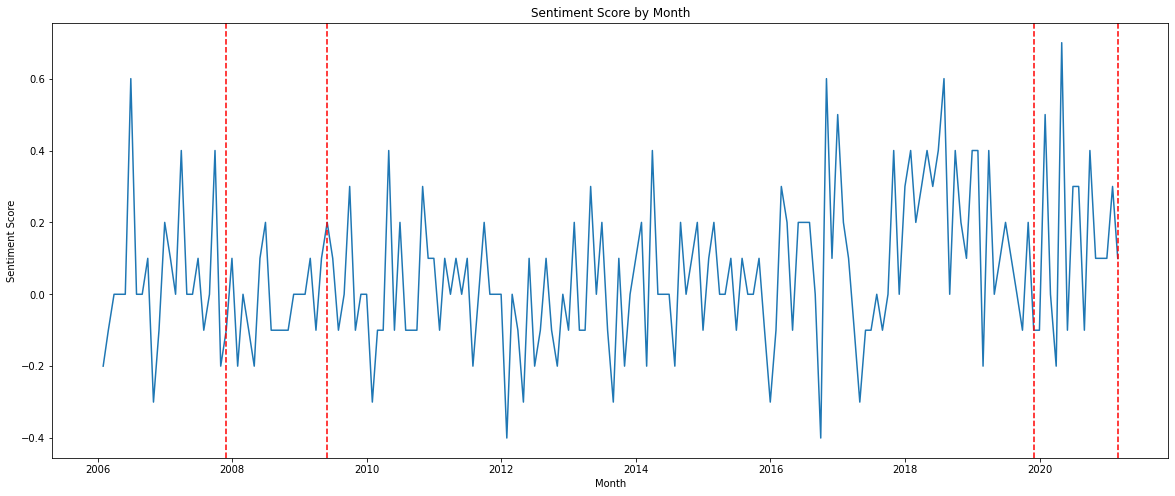

In [104]:
import datetime
month_date = list(pd.to_datetime(df.date[:-1]))
sentiment_score = list(text_sentiments.sentiments)
plt.figure(figsize=(20,8))
plt.plot(month_date, sentiment_score)
plt.title("Sentiment Score by Month")
plt.xlabel('Month')
plt.ylabel('Sentiment Score')
# plt.text(x=0,y=0, s="2007-", fontsize=2)
plt.axvline(x=datetime.datetime(2007,12,1), color='red', linestyle='--')
plt.axvline(x=datetime.datetime(2009,6,1), color='red', linestyle='--')
plt.axvline(x=datetime.datetime(2019,12,1), color='red', linestyle='--')
plt.axvline(x=datetime.datetime(2021,3,1), color='red', linestyle='--')
plt.show()

Financial Crisis 2007-2008: Sentiment scores during this period remain relatively low with a maximum score of about 0.2.

COVID-19 Pandemic: The start of COVID-19 has highly volatile sentiments as it is uncertain how the pandemic will affect the economy. 2021 shows a positive sentiment and this could be due to the distribution of vaccine.